# Predicting Uber Ride Cancellations using Exploratory Data Analysis and Machine Learning

Source Dataset: https://www.kaggle.com/datasets/yashdevladdha/uber-ride-analytics-dashboard/data

**Domain**: Urban Mobility & Ride-Hailing Analytics

**Objective**: Build a predictive model to determine whether a customer will cancel a ride before it begins, using only the booking metadata available at the time of booking. The goal is to help the platform proactively identify high-risk cancellations and optimize driver dispatch efficiency.

## Data Extraction

Import Kaggle Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tirthankar Raha\.cache\kagglehub\datasets\yashdevladdha\uber-ride-analytics-dashboard\versions\2


## Initiation

Import Libraries

In [4]:
# Basic imports for data analysis
import pandas as pd
import numpy as np

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for data modeling
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance

# Set pandas display options for full visibility
pd.set_option('display.max_columns', None)

# Hide future warnings
import warnings; warnings.filterwarnings('ignore')

In [5]:
# Load dataset
df = pd.read_csv(r"C:\Users\Tirthankar Raha\.cache\kagglehub\datasets\yashdevladdha\uber-ride-analytics-dashboard\versions\2\ncr_ride_bookings.csv")
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [249]:
df[df['cancelled_rides_by_customer'] == 1]['payment_method'].unique()

array([nan], dtype=object)

Review Data

In [6]:
# Variable overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

- Refer to the column definitions below:


| Column Name                     | Description                                                                  |
|---------------------------------|------------------------------------------------------------------------------|
| Date                            | Date of the booking                                                          |
| Time                            | Time of the booking                                                          |
| Booking ID                      | Unique identifier for each ride booking                                      |
| Booking Status                  | Status of booking (Completed, Cancelled by Customer, Cancelled by Driver, etc.) |
| Customer ID                     | Unique identifier for customers                                              |
| Vehicle Type                    | Type of vehicle (Go Mini, Go Sedan, Auto, eBike/Bike, UberXL, Premier Sedan) |
| Pickup Location                 | Starting location of the ride                                                |
| Drop Location                   | Destination location of the ride                                             |
| Avg VTAT                        | Average time for driver to reach pickup location (in minutes)                |
| Avg CTAT                        | Average trip duration from pickup to destination (in minutes)                |
| Cancelled Rides by Customer     | Customer-initiated cancellation flag                                         |
| Reason for cancelling by Customer | Reason for customer cancellation                                           |
| Cancelled Rides by Driver       | Driver-initiated cancellation flag                                           |
| Driver Cancellation Reason      | Reason for driver cancellation                                               |
| Incomplete Rides                | Incomplete ride flag                                                         |
| Incomplete Rides Reason         | Reason for incomplete rides                                                  |
| Booking Value                   | Total fare amount for the ride                                               |
| Ride Distance                   | Distance covered during the ride (in km)                                     |
| Driver Ratings                  | Rating given to driver (1-5 scale)                                           |
| Customer Rating                 | Rating given by customer (1-5 scale)                                         |
| Payment Method                  | Method used for payment (UPI, Cash, Credit Card, Uber Wallet, Debit Card)    |


**Observations**:

- Multiple columns have missing values.
- Column names have inconsistent naming conventions (e.g., Uppercase and spaces).
- Columns 'Date' and 'Time' are date/time variables, which would need to be converted to the correct format.
- Columns 'Booking ID' and 'Customer ID' have values with " " quotes, which needs to be stripped.

In [7]:
# Summary statistics
df.describe(include= 'all')

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
count,150000,150000,150000,150000,150000,150000,150000,150000,139500.000000,102000.000000,10500.0,10500,27000.0,27000,9000.0,9000,102000.000000,102000.000000,93000.000000,93000.000000,102000
unique,365,62910,148767,5,148788,7,176,176,NaN,NaN,NaN,5,NaN,4,NaN,3,NaN,NaN,NaN,NaN,5
top,2024-11-16,17:44:57,"""CNR3648267""",Completed,"""CID6715450""",Auto,Khandsa,Ashram,NaN,NaN,NaN,Wrong Address,NaN,Customer related issue,NaN,Customer Demand,NaN,NaN,NaN,NaN,UPI
freq,462,16,3,93000,3,37419,949,936,NaN,NaN,NaN,2362,NaN,6837,NaN,3040,NaN,NaN,NaN,NaN,45909
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.456352,29.149636,1.0,NaN,1.0,NaN,1.0,NaN,508.295912,24.637012,4.230992,4.404584,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.773564,8.902577,0.0,NaN,0.0,NaN,0.0,NaN,395.805774,14.002138,0.436871,0.437819,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,10.000000,1.0,NaN,1.0,NaN,1.0,NaN,50.000000,1.000000,3.000000,3.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300000,21.600000,1.0,NaN,1.0,NaN,1.0,NaN,234.000000,12.460000,4.100000,4.200000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.300000,28.800000,1.0,NaN,1.0,NaN,1.0,NaN,414.000000,23.720000,4.300000,4.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.300000,36.800000,1.0,NaN,1.0,NaN,1.0,NaN,689.000000,36.820000,4.600000,4.800000,NaN


**Observations**:

- All data columns seem to be well distributed, though max. booking value of 4277 seems to be an outlier.
Based on our observations from above, we can plan our initial approach as below:

- Data Pre-Procesing:
    - Modify columns/values as needed
    - Check/eliminate/deal with duplicates
    - Check/eliminate/deal with Nulls
- Exploratory Data Analysis

## Data Pre-processing

Clean and standardize column names

In [8]:
# Replace spaces with underscores for easier referencing in code
# Convert all letters to lowercase for consistency
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


Date & Time Features Conversion and Extraction

In [9]:
# Combine 'Date' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Drop original columns if not needed
df.drop(['date', 'time'], axis=1, inplace=True)

In [10]:
# Verify the change
print(df.info())
print(df[['datetime']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   booking_id                         150000 non-null  object        
 1   booking_status                     150000 non-null  object        
 2   customer_id                        150000 non-null  object        
 3   vehicle_type                       150000 non-null  object        
 4   pickup_location                    150000 non-null  object        
 5   drop_location                      150000 non-null  object        
 6   avg_vtat                           139500 non-null  float64       
 7   avg_ctat                           102000 non-null  float64       
 8   cancelled_rides_by_customer        10500 non-null   float64       
 9   reason_for_cancelling_by_customer  10500 non-null   object        
 10  cancelled_rides_by_d

In [11]:
# Extract datetime features for further analysis and modeling
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['weekday'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

df.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


Cleaning data values

In [12]:
# Remove double quotes from column values of 'booking_id' and 'customer_id' for consistency
df['booking_id'] = df['booking_id'].str.strip('"')
df['customer_id'] = df['customer_id'].str.strip('"')
df.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


In [13]:
# Check unique values in categorical columns
print("Vehicle Types:", df['vehicle_type'].unique())
print("Booking statuses:", df['booking_status'].unique())

Vehicle Types: ['eBike' 'Go Sedan' 'Auto' 'Premier Sedan' 'Bike' 'Go Mini' 'Uber XL']
Booking statuses: ['No Driver Found' 'Incomplete' 'Completed' 'Cancelled by Driver'
 'Cancelled by Customer']


Check/eliminate/deal with duplicates

In [14]:
# check for duplicate rows 
df.duplicated().sum()

np.int64(0)

In [15]:
# Check for missing Booking IDs and Customer IDs 
print(df['booking_id'].isnull().sum())
print(df['customer_id'].isnull().sum())

0
0


In [16]:
# Check for duplicate Booking IDs
dup_mask = df['booking_id'].duplicated(keep='first')
print("duplicate rows :", dup_mask.sum())
df[dup_mask].head()

duplicate rows : 1233


,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
5522,CNR5071968,No Driver Found,CID6309096,Auto,Kanhaiya Nagar,India Gate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-10 19:55:06,19,Sunday,6,3,True
7762,CNR8512595,Completed,CID9741888,Go Mini,Narsinghpur,Huda City Centre,3.5,15.4,NaN,NaN,NaN,NaN,NaN,NaN,187.0,41.45,4.4,4.2,Credit Card,2024-03-01 11:55:56,11,Friday,4,3,False
9587,CNR1029172,Completed,CID6382731,Auto,Inderlok,Laxmi Nagar,6.9,34.4,NaN,NaN,NaN,NaN,NaN,NaN,332.0,36.38,4.3,4.3,UPI,2024-12-17 19:19:02,19,Tuesday,1,12,False
9726,CNR7132372,Completed,CID6950827,Go Sedan,Kalkaji,Sushant Lok,3.8,18.3,NaN,NaN,NaN,NaN,NaN,NaN,389.0,44.95,3.7,4.2,UPI,2024-05-23 20:44:27,20,Thursday,3,5,False
10186,CNR7768664,Completed,CID4473762,eBike,Anand Vihar ISBT,Netaji Subhash Place,5.1,42.1,NaN,NaN,NaN,NaN,NaN,NaN,357.0,17.03,4.2,4.2,UPI,2024-12-14 21:15:59,21,Saturday,5,12,True


In [17]:
# Inspect duplicate booking_ids so as to know if the duplicate booking_ids are created due to 'No driver found' booking_status
df[df['booking_id']=='CNR5071968']

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
317,CNR5071968,Completed,CID7384045,Go Sedan,Panchsheel Park,Yamuna Bank,4.7,42.5,NaN,NaN,NaN,NaN,NaN,NaN,473.0,48.35,4.7,3.8,Cash,2024-10-10 03:56:19,3,Thursday,3,10,False
5522,CNR5071968,No Driver Found,CID6309096,Auto,Kanhaiya Nagar,India Gate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-10 19:55:06,19,Sunday,6,3,True


In [18]:
df[df['booking_id']=='CNR8512595']

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
1893,CNR8512595,Completed,CID8017027,Auto,Ashok Vihar,Mehrauli,14.6,29.6,NaN,NaN,NaN,NaN,NaN,NaN,294.0,44.22,3.6,5.0,Cash,2024-11-02 10:45:25,10,Saturday,5,11,True
7762,CNR8512595,Completed,CID9741888,Go Mini,Narsinghpur,Huda City Centre,3.5,15.4,NaN,NaN,NaN,NaN,NaN,NaN,187.0,41.45,4.4,4.2,Credit Card,2024-03-01 11:55:56,11,Friday,4,3,False


There are duplicate booking_ids for multiple completed rides. Hence, we will keep all rows with duplicate booking_ids in our dataset but will drop 'booking_id' column before our modeling so that we don't lose the information from these rows.

In [19]:
pd.crosstab(df['cancelled_rides_by_customer'],df['driver_ratings'],dropna=False)

driver_ratings,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,NaN
cancelled_rides_by_customer,,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10500
NaN,745,1459,1538,1461,1491,748,2026,3790,3848,3915,1995,6966,13841,14081,7018,4634,9368,4678,2328,4705,2365,46500


In [20]:
pd.crosstab(df['cancelled_rides_by_customer'],df['customer_rating'],dropna=False)

customer_rating,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,NaN
cancelled_rides_by_customer,,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10500
NaN,468,1008,881,900,928,443,1194,2354,2357,2370,1185,5396,10697,10995,5279,5890,11533,5763,5880,11642,5837,46500


Driver and Customer Ratings are not available for any bookings wherein the customer cancelled the ride.

In [21]:
# Check for Nulls
df.isna().sum()

booking_id                                0
booking_status                            0
customer_id                               0
vehicle_type                              0
pickup_location                           0
drop_location                             0
avg_vtat                              10500
avg_ctat                              48000
cancelled_rides_by_customer          139500
reason_for_cancelling_by_customer    139500
cancelled_rides_by_driver            123000
driver_cancellation_reason           123000
incomplete_rides                     141000
incomplete_rides_reason              141000
booking_value                         48000
ride_distance                         48000
driver_ratings                        57000
customer_rating                       57000
payment_method                        48000
datetime                                  0
hour                                      0
day_of_week                               0
weekday                         

**Treating NaNs**:

- avg_vtat, avg_ctat
- cancelled_rides_by_customer, cancelled_rides_by_driver, incomplete_rides
- reason_for_cancelling_by_customer, driver_cancellation_reason, incomplete_rides_reason ---*this will be dropped before modelling as it is not required*.
- booking_value, ride_distance, driver_ratings, customer_rating, payment_method

In [22]:
# Check for missing values in 'avg_vtat' 
df[df['avg_vtat'].isnull()].head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
8,CNR4510807,No Driver Found,CID7873618,Go Sedan,Noida Sector 62,Noida Sector 18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-14 12:49:09,12,Saturday,5,9,True
11,CNR9551927,No Driver Found,CID7568143,Auto,Vidhan Sabha,AIIMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-18 08:09:38,8,Wednesday,2,9,False
27,CNR4499383,No Driver Found,CID5717521,Premier Sedan,Sadar Bazar Gurgaon,Mehrauli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-12 19:42:35,19,Friday,4,4,False
57,CNR9773309,No Driver Found,CID9965847,Uber XL,Anand Vihar ISBT,Dwarka Sector 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-11 15:43:34,15,Thursday,3,4,False


In [23]:
# Check which booking statuses have missing 'avg_vtat' and 'avg_ctat'
print('Missing avg_vtat:',df[df['avg_vtat'].isnull()]['booking_status'].unique())
print('Missing avg_ctat:',df[df['avg_ctat'].isnull()]['booking_status'].unique())

Missing avg_vtat: ['No Driver Found']
Missing avg_ctat: ['No Driver Found' 'Cancelled by Driver' 'Cancelled by Customer']


avg_vtat (driver arrival time) is only null in case when the driver was not found.

In [24]:
# Check booking statuses for rides cancelled by customer
df[df['cancelled_rides_by_customer']==1]['booking_status'].unique()

array(['Cancelled by Customer'], dtype=object)

All rides cancelled by customer have a booking status of 'Cancelled by Customer'

In [25]:
# cancelled_rides_by_customer vs booking_status 
pd.crosstab(df['booking_status'], df['cancelled_rides_by_customer'], dropna=False)

cancelled_rides_by_customer,1.0,NaN
booking_status,,
Cancelled by Customer,10500,0
Cancelled by Driver,0,27000
Completed,0,93000
Incomplete,0,9000
No Driver Found,0,10500


In [26]:
# cancelled_rides_by_driver vs booking_status 
pd.crosstab(df['booking_status'], df['cancelled_rides_by_driver'], dropna=False)

cancelled_rides_by_driver,1.0,NaN
booking_status,,
Cancelled by Customer,0,10500
Cancelled by Driver,27000,0
Completed,0,93000
Incomplete,0,9000
No Driver Found,0,10500


All of the above confirm that:

- avg_vtat (driver arrival time) is only null in case when the driver was not found. So, there are no null values for actual accepted rides. However, we need to impute their medians for modeling purpose.
- All rides cancelled by customer have a booking status of 'Cancelled by Customer'
- All rides cancelled by driver have a booking status of 'Cancelled by Driver'
- Therefore, these null values are expected and do not indicate data quality issues.

In [27]:
print(df['pickup_location'].nunique())
print(df['drop_location'].nunique())

176
176


In [28]:
# Create a copy of the original dataframe
df1 = df.copy()
df1.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


In [29]:
# impute median 'avg_vtat' and 'avg_ctat' by 'vehicle_type' and 'pickup_location'
for col in ['avg_vtat', 'avg_ctat']:
    df1[col] = df1[col].fillna(df1.groupby(['vehicle_type','pickup_location'])[col].transform('median'))

df1.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,9.7,28.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.80,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.50,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.60,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


In [30]:
df1['avg_ctat'].isnull().sum()

np.int64(0)

In [31]:
# impute nulls as O for "not cancelled" rides
for col in ['cancelled_rides_by_customer', 'cancelled_rides_by_driver', 'incomplete_rides']:
    df1[col] = df1[col].fillna(0).astype(int)

df1.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,9.7,28.15,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,0,NaN,0,NaN,1,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.80,0,NaN,0,NaN,0,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.50,0,NaN,0,NaN,0,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.60,0,NaN,0,NaN,0,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


In [32]:
# impute medians for 'booking_value', 'ride_distance', 'driver_ratings', 'customer_rating'
for col in ['booking_value', 'ride_distance', 'driver_ratings', 'customer_rating']:
    df1[col].fillna(df1[col].median(), inplace=True)

df1.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,9.7,28.15,0,NaN,0,NaN,0,NaN,414.0,23.72,4.3,4.5,NaN,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,0,NaN,0,NaN,1,Vehicle Breakdown,237.0,5.73,4.3,4.5,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.80,0,NaN,0,NaN,0,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.50,0,NaN,0,NaN,0,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.60,0,NaN,0,NaN,0,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


In [33]:
print(df1['payment_method'].value_counts())

pd.crosstab(df1['payment_method'], df1['booking_status'], dropna=False)

payment_method
UPI            45909
Cash           25367
Uber Wallet    12276
Credit Card    10209
Debit Card      8239
Name: count, dtype: int64


booking_status,Cancelled by Customer,Cancelled by Driver,Completed,Incomplete,No Driver Found
payment_method,,,,,
Cash,0,0,23114,2253,0
Credit Card,0,0,9320,889,0
Debit Card,0,0,7526,713,0
UPI,0,0,41834,4075,0
Uber Wallet,0,0,11206,1070,0
NaN,10500,27000,0,0,10500


We don't have payment method details for booking statuses as customer cancelled, driver cancelled or no driver found.

In [34]:
df1['payment_method'] = df1['payment_method'].fillna('Unknown')
df1.head()

,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method,datetime,hour,day_of_week,weekday,month,is_weekend
0,CNR5884300,No Driver Found,CID1982111,eBike,Palam Vihar,Jhilmil,9.7,28.15,0,NaN,0,NaN,0,NaN,414.0,23.72,4.3,4.5,Unknown,2024-03-23 12:29:38,12,Saturday,5,3,True
1,CNR1326809,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,0,NaN,0,NaN,1,Vehicle Breakdown,237.0,5.73,4.3,4.5,UPI,2024-11-29 18:01:39,18,Friday,4,11,False
2,CNR8494506,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.80,0,NaN,0,NaN,0,NaN,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,Friday,4,8,False
3,CNR8906825,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.50,0,NaN,0,NaN,0,NaN,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,Monday,0,10,False
4,CNR1950162,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.60,0,NaN,0,NaN,0,NaN,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,Monday,0,9,False


## Exploratory Data Analysis

- Median VTAT by Vehicle Type
- Top 10 pick-up and drop-off locations by avg. VTAT
- Cancellation patterns: By hour, weekday/weekend, vehicle type, and location.
- Customer behavior: Analyze repeat cancellations per customer.
- Operational metrics: Impact of higher avg_vtat (driver arrival time), avg_ctat(ride time) on cancellations.  

Notes:

- For cancelled rides, the variables 'ride distance', 'booking value', 'customer rating', and 'driver rating' contain null values, as these metrics are only recorded for successfully completed rides. Consequently, Exploratory Data Analysis (EDA) on these variables is not feasible for cancelled rides.

- Although a deeper analysis of cancellation patterns could be conducted by:
    - Estimating ride distance — e.g., calculating the geodesic distance between pickup and drop-off coordinates, and
    - Assessing rating correlations — e.g., comparing average customer or driver ratings across a larger dataset, such analyses fall outside the scope of the current project due to dataset constraints and limited sample size.

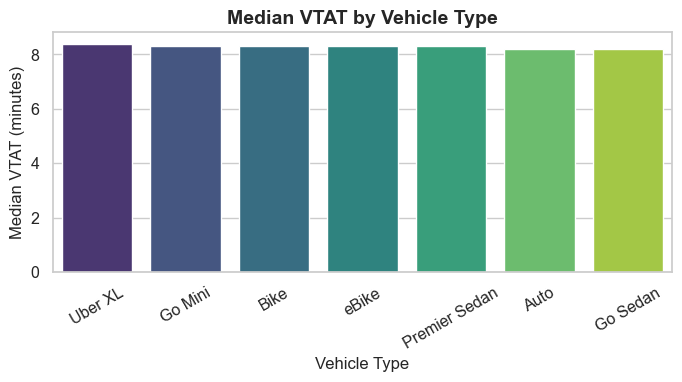

In [35]:
# --- Median VTAT by Vehicle Type ---
plt.figure(figsize=(7, 4))
sns.set_theme(style="whitegrid", font_scale=1.05)

order = df.groupby('vehicle_type')['avg_vtat'].median().sort_values(ascending=False).index
sns.barplot(x='vehicle_type', y='avg_vtat', data=df, order=order, palette='viridis', estimator='median', errorbar=None)

plt.title('Median VTAT by Vehicle Type', fontsize=14, weight='bold')
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Median VTAT (minutes)', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

There isn't much variance in Median VTAT across Vehicle Types.

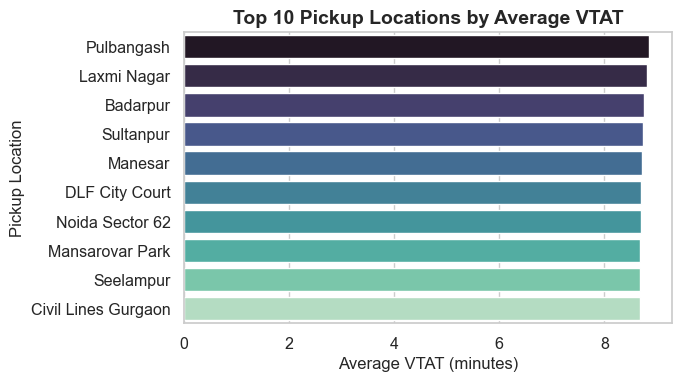

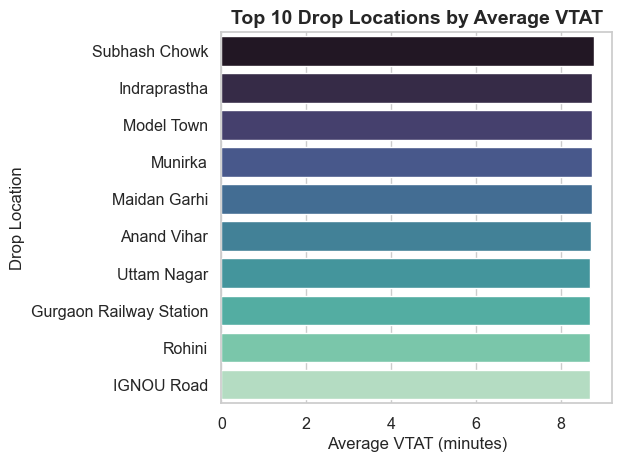

In [36]:
# --- Top 10 Pickup/Drop Locations by Avg VTAT ---
plt.figure(figsize=(7, 4))

for col, title in [('pickup_location', 'Top 10 Pickup Locations by Average VTAT'),
                   ('drop_location', 'Top 10 Drop Locations by Average VTAT')]:
    top = df.groupby(col)['avg_vtat'].mean().nlargest(10).reset_index()
    sns.barplot(x='avg_vtat', y=col, data=top, palette='mako', hue=col, dodge=False, legend=False)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Average VTAT (minutes)', fontsize=12)
    plt.ylabel(col.replace('_',' ').title(), fontsize=12)
    plt.tight_layout()
    plt.show()

### Cancellation Patterns

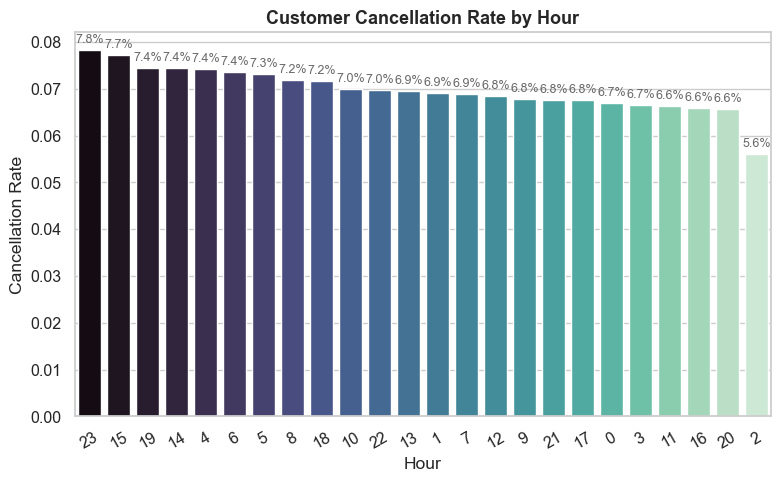

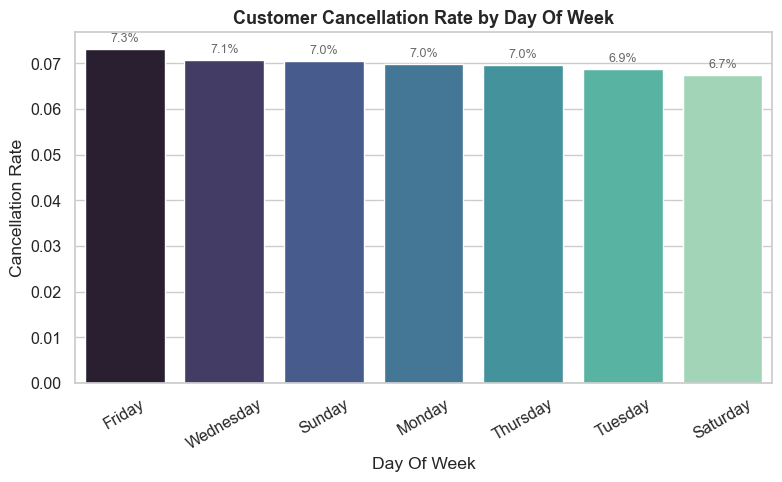

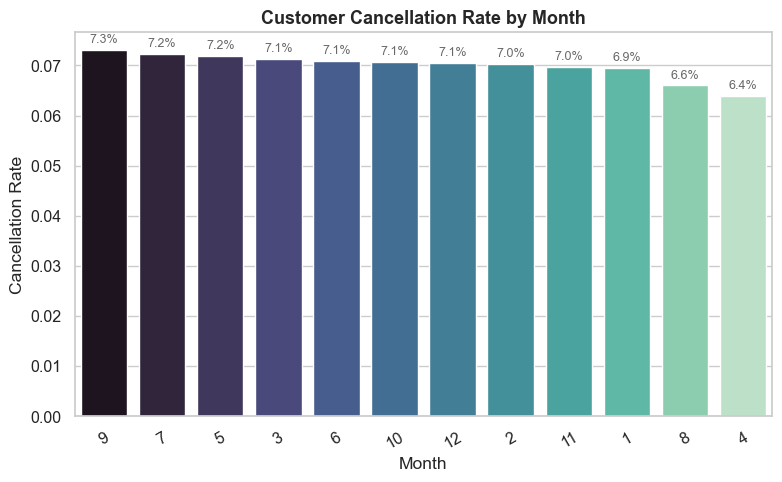

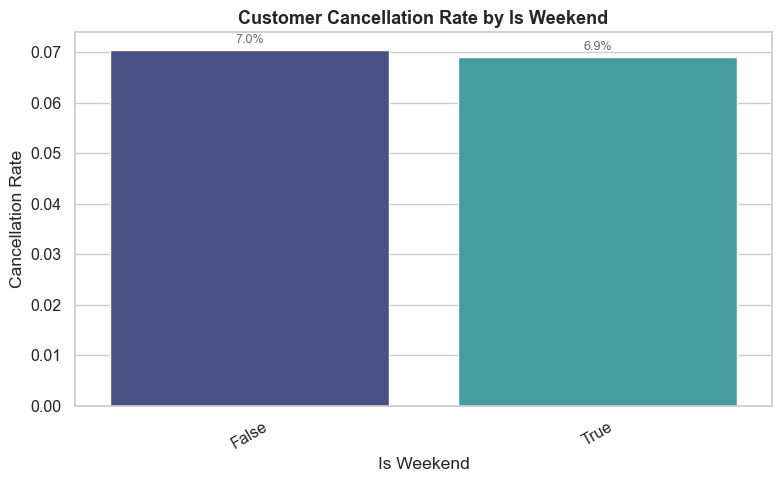

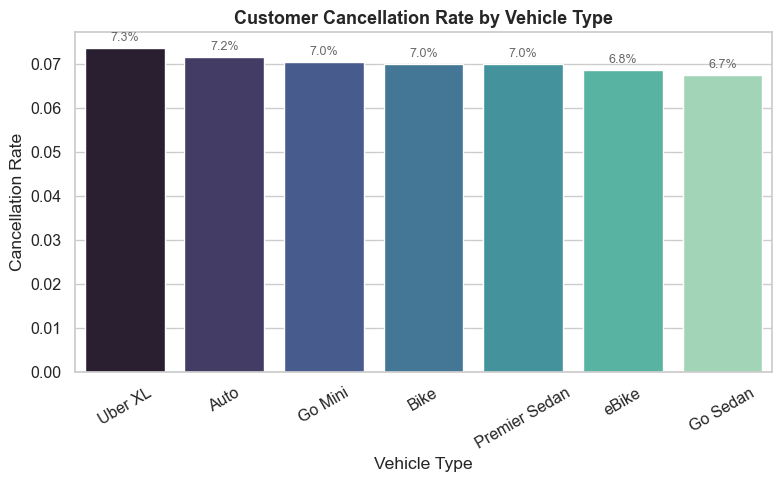

In [37]:
# --- Customer Cancellation Rate by Various Features ---
for col in ['hour','day_of_week','month','is_weekend','vehicle_type']:
    order = df1.groupby(col)['cancelled_rides_by_customer'].mean().sort_values(ascending=False).index
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=col, y='cancelled_rides_by_customer', data=df1, order=order, palette='mako', errorbar=None)
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='dimgray', xytext=(0, 3), textcoords='offset points')
    
    plt.title(f'Customer Cancellation Rate by {col.replace("_"," ").title()}', fontsize=13, weight='bold')
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

**Observations**:
1. Customer Cancellation rate (%) is highest at 23:00 and 15:00 hours per day, on Fridays
2. Customer Cancellation rate (%) is highest on Fridays followed by Wednesday.
3. Customer Cancellation rate (%) is highest in September and July.
4. There doesn't seem to be much difference in Customer Cancellation rate (%) between weekdays and weekends.
5. We have higher Customer Cancellation rate (%) for Uber XL bookings and Auto.

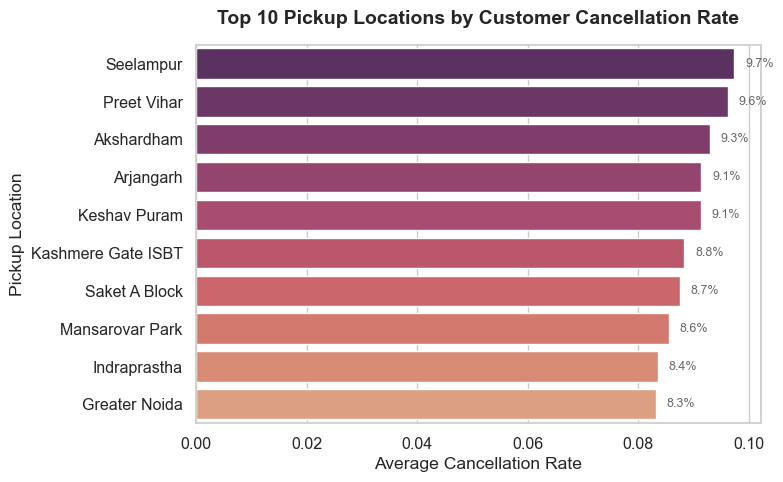

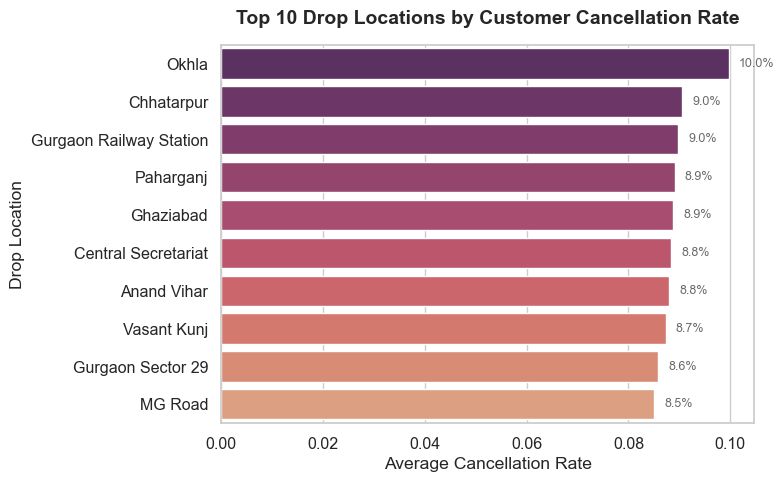

In [38]:
for col, title in [('pickup_location', 'Top 10 Pickup Locations by Customer Cancellation Rate'),
                   ('drop_location', 'Top 10 Drop Locations by Customer Cancellation Rate')]:
    agg = df1.groupby(col)['cancelled_rides_by_customer'].mean().nlargest(10).reset_index()
    colors = sns.color_palette('flare', len(agg))[::-1]
    plt.figure(figsize=(8,5))
    ax = sns.barplot(y=col, x='cancelled_rides_by_customer', data=agg, palette=colors, legend=False, orient='h')

    for p in ax.patches:
        ax.text(p.get_width()+0.002, p.get_y()+p.get_height()/2, f"{p.get_width():.1%}", va='center', fontsize=9, color='dimgray')

    plt.title(title, fontsize=14, weight='bold', pad=15)
    plt.xlabel('Average Cancellation Rate')
    plt.ylabel(col.replace('_',' ').title())
    plt.tight_layout()
    plt.show()

*Customer Cancellation rate (%) is highest from pickup location 'Seelampur' and with drop location 'Okhla'*.

### Customer Behavior

In [39]:
df1[df1['cancelled_rides_by_customer']==1].groupby('customer_id').size().sort_values(ascending=False).head(10).reset_index()  

,customer_id,0
0,CID5488244,2
1,CID5251785,2
2,CID2358909,2
3,CID5505307,2
4,CID7939117,2
5,CID8416905,2
6,CID8519067,2
7,CID8887672,2
8,CID9990678,1
9,CID9990260,1


We don't have many repeated customer cancellations. Only 7 customers have cancelled twice. So, there is no pattern of cancelled rides with customer IDs.

### Operational Metrics

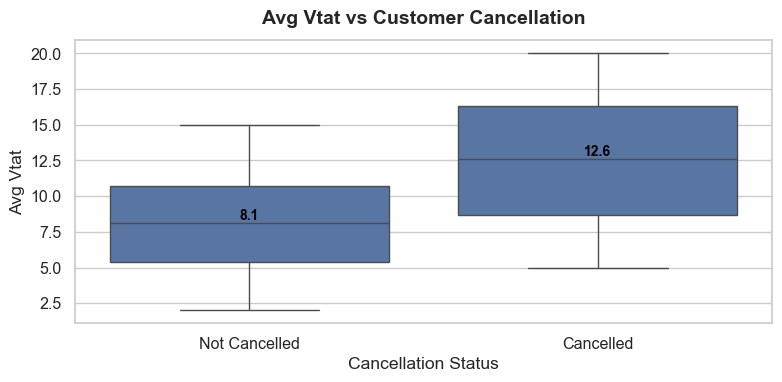

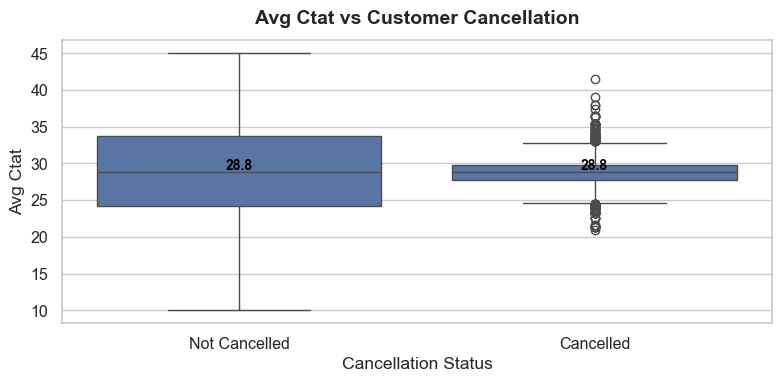

In [40]:
for col in ['avg_vtat', 'avg_ctat']:
    plt.figure(figsize=(8,4))
    ax = sns.boxplot(x='cancelled_rides_by_customer', y=col, data=df1)
    
    medians = df1.groupby('cancelled_rides_by_customer')[col].median()
    for i, median in enumerate(medians):
        ax.text(i, median, f"{median:.1f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')
    
    plt.title(f"{col.replace('_',' ').title()} vs Customer Cancellation", fontsize=14, weight='bold', pad=12)
    plt.xticks([0,1], ['Not Cancelled','Cancelled'])
    plt.xlabel("Cancellation Status")
    plt.ylabel(col.replace('_',' ').title())
    plt.tight_layout()
    plt.show()

*We can clearly see here that avg_vtat (driver arrival time) is higher for cancelled rides with a median around 12.5 minutes and for not cancelled rides is around 7.5 minutes. So, avg_vtat is our key driver that coorelate with customer cancellations.*  

## Feature Engineering

Enhance predictive power with derived features such as:

- Time-based: Is_Peak_Hour
- Location-based: Encode frequent cancellation zones using frequency encoding.

In [41]:
# Define peak hours: 7-10 AM and 5-8 PM
df1['is_peak_hour'] = df1['hour'].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 20) else 0)
df1[['hour','is_peak_hour']].head(10)

,hour,is_peak_hour
0,12,0
1,18,1
2,8,1
3,17,1
4,22,0
5,9,1
6,15,0
7,17,1
8,12,0
9,19,1


In [42]:
# Encoding categorical variables
df1 = pd.get_dummies(df1, columns=['vehicle_type', 'day_of_week', 'payment_method'], drop_first=True)
df1.head()

,booking_id,booking_status,customer_id,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,datetime,hour,weekday,month,is_weekend,is_peak_hour,vehicle_type_Bike,vehicle_type_Go Mini,vehicle_type_Go Sedan,vehicle_type_Premier Sedan,vehicle_type_Uber XL,vehicle_type_eBike,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,payment_method_Credit Card,payment_method_Debit Card,payment_method_UPI,payment_method_Uber Wallet,payment_method_Unknown
0,CNR5884300,No Driver Found,CID1982111,Palam Vihar,Jhilmil,9.7,28.15,0,NaN,0,NaN,0,NaN,414.0,23.72,4.3,4.5,2024-03-23 12:29:38,12,5,3,True,0,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True
1,CNR1326809,Incomplete,CID4604802,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,0,NaN,0,NaN,1,Vehicle Breakdown,237.0,5.73,4.3,4.5,2024-11-29 18:01:39,18,4,11,False,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,CNR8494506,Completed,CID9202816,Khandsa,Malviya Nagar,13.4,25.80,0,NaN,0,NaN,0,NaN,627.0,13.58,4.9,4.9,2024-08-23 08:56:10,8,4,8,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,CNR8906825,Completed,CID2610914,Central Secretariat,Inderlok,13.1,28.50,0,NaN,0,NaN,0,NaN,416.0,34.02,4.6,5.0,2024-10-21 17:17:25,17,0,10,False,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False
4,CNR1950162,Completed,CID9933542,Ghitorni Village,Khan Market,5.3,19.60,0,NaN,0,NaN,0,NaN,737.0,48.21,4.1,4.3,2024-09-16 22:08:00,22,0,9,False,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [43]:
# Encoding top 10 pickup and drop locations and creating dummies

for col, prefix in [('pickup_location', 'pickup'), ('drop_location', 'drop')]:
    # Top 10 overall and top 10 for customer cancellations
    top = df1[col].value_counts().nlargest(10).index
    top_canc = df1.loc[df1['cancelled_rides_by_customer']==1, col].value_counts().nlargest(10).index
    
    # Encode top locations, others as 'Other'
    df1[f'{col}_encoded'] = df1[col].where(df1[col].isin(top), 'Other')
    df1[f'{col}_encoded_cus_canc'] = df1[col].where(df1[col].isin(top_canc), 'Other')
    
    # Create dummy variables
    df1 = pd.get_dummies(df1, columns=[f'{col}_encoded', f'{col}_encoded_cus_canc'], prefix=[prefix, f'{prefix}_cus_canc'], drop_first=True)

df1.head()

,booking_id,booking_status,customer_id,pickup_location,drop_location,avg_vtat,avg_ctat,cancelled_rides_by_customer,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,datetime,hour,weekday,month,is_weekend,is_peak_hour,vehicle_type_Bike,vehicle_type_Go Mini,vehicle_type_Go Sedan,vehicle_type_Premier Sedan,vehicle_type_Uber XL,vehicle_type_eBike,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,payment_method_Credit Card,payment_method_Debit Card,payment_method_UPI,payment_method_Uber Wallet,payment_method_Unknown,pickup_Badarpur,pickup_Barakhamba Road,pickup_Dwarka Sector 21,pickup_Khandsa,pickup_Madipur,pickup_Mehrauli,pickup_Other,pickup_Pataudi Chowk,pickup_Pragati Maidan,pickup_Saket,pickup_cus_canc_Arjangarh,pickup_cus_canc_Greater Kailash,pickup_cus_canc_Greater Noida,pickup_cus_canc_Kashmere Gate ISBT,pickup_cus_canc_Keshav Puram,pickup_cus_canc_Mansarovar Park,pickup_cus_canc_Other,pickup_cus_canc_Preet Vihar,pickup_cus_canc_Saket A Block,pickup_cus_canc_Seelampur,drop_Basai Dhankot,drop_Cyber Hub,drop_Kalkaji,drop_Kashmere Gate ISBT,drop_Lajpat Nagar,drop_Lok Kalyan Marg,drop_Madipur,drop_Narsinghpur,drop_Other,drop_Udyog Vihar,drop_cus_canc_Bahadurgarh,drop_cus_canc_Central Secretariat,drop_cus_canc_Chhatarpur,drop_cus_canc_Ghaziabad,drop_cus_canc_Gurgaon Railway Station,drop_cus_canc_Kalkaji,drop_cus_canc_Okhla,drop_cus_canc_Other,drop_cus_canc_Paharganj,drop_cus_canc_Uttam Nagar
0,CNR5884300,No Driver Found,CID1982111,Palam Vihar,Jhilmil,9.7,28.15,0,NaN,0,NaN,0,NaN,414.0,23.72,4.3,4.5,2024-03-23 12:29:38,12,5,3,True,0,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
1,CNR1326809,Incomplete,CID4604802,Shastri Nagar,Gurgaon Sector 56,4.9,14.00,0,NaN,0,NaN,1,Vehicle Breakdown,237.0,5.73,4.3,4.5,2024-11-29 18:01:39,18,4,11,False,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
2,CNR8494506,Completed,CID9202816,Khandsa,Malviya Nagar,13.4,25.80,0,NaN,0,NaN,0,NaN,627.0,13.58,4.9,4.9,2024-08-23 08:56:10,8,4,8,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,CNR8906825,Completed,CID2610914,Central Secretariat,Inderlok,13.1,28.50,0,NaN,0,NaN,0,NaN,416.0,34.02,4.6,5.0,2024-10-21 17:17:25,17,0,10,False,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
4,CNR1950162,Completed,CID9933542,Ghitorni Village,Khan Market,5.3,19.60,0,NaN,0,NaN,0,NaN,737.0,48.21,4.1,4.3,2024-09-16 22:08:00,22,0,9,False,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fal

In [44]:
# Drop unnecessary columns
df1 = df1.drop(['booking_id', 'booking_status', 'pickup_location', 'drop_location', 'reason_for_cancelling_by_customer', 
                'driver_cancellation_reason', 'cancelled_rides_by_driver', 'incomplete_rides', 'incomplete_rides_reason', 'datetime'], axis=1)
df1.head()

,customer_id,avg_vtat,avg_ctat,cancelled_rides_by_customer,booking_value,ride_distance,driver_ratings,customer_rating,hour,weekday,month,is_weekend,is_peak_hour,vehicle_type_Bike,vehicle_type_Go Mini,vehicle_type_Go Sedan,vehicle_type_Premier Sedan,vehicle_type_Uber XL,vehicle_type_eBike,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,payment_method_Credit Card,payment_method_Debit Card,payment_method_UPI,payment_method_Uber Wallet,payment_method_Unknown,pickup_Badarpur,pickup_Barakhamba Road,pickup_Dwarka Sector 21,pickup_Khandsa,pickup_Madipur,pickup_Mehrauli,pickup_Other,pickup_Pataudi Chowk,pickup_Pragati Maidan,pickup_Saket,pickup_cus_canc_Arjangarh,pickup_cus_canc_Greater Kailash,pickup_cus_canc_Greater Noida,pickup_cus_canc_Kashmere Gate ISBT,pickup_cus_canc_Keshav Puram,pickup_cus_canc_Mansarovar Park,pickup_cus_canc_Other,pickup_cus_canc_Preet Vihar,pickup_cus_canc_Saket A Block,pickup_cus_canc_Seelampur,drop_Basai Dhankot,drop_Cyber Hub,drop_Kalkaji,drop_Kashmere Gate ISBT,drop_Lajpat Nagar,drop_Lok Kalyan Marg,drop_Madipur,drop_Narsinghpur,drop_Other,drop_Udyog Vihar,drop_cus_canc_Bahadurgarh,drop_cus_canc_Central Secretariat,drop_cus_canc_Chhatarpur,drop_cus_canc_Ghaziabad,drop_cus_canc_Gurgaon Railway Station,drop_cus_canc_Kalkaji,drop_cus_canc_Okhla,drop_cus_canc_Other,drop_cus_canc_Paharganj,drop_cus_canc_Uttam Nagar
0,CID1982111,9.7,28.15,0,414.0,23.72,4.3,4.5,12,5,3,True,0,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
1,CID4604802,4.9,14.00,0,237.0,5.73,4.3,4.5,18,4,11,False,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
2,CID9202816,13.4,25.80,0,627.0,13.58,4.9,4.9,8,4,8,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,CID2610914,13.1,28.50,0,416.0,34.02,4.6,5.0,17,0,10,False,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
4,CID9933542,5.3,19.60,0,737.0,48.21,4.1,4.3,22,0,9,False,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False


## Model Building

Train supervised models to predict cancellation probability.

Models:

- Logistic Regression
- Random Forest
- XGBoost  

Pipeline:

- Split data into train/test sets (e.g., 70/30).
- Optimize hyperparameters using GridSearch.
- Evaluate with relevant metrics (we'll focus model tuning to optimize *F1 score*, as we want to balance identifying maximum positives and ensuring majority of predicted positives are correct).

In [45]:
# 1. Train-Test Split

# Features and target variable
X = df1.drop('cancelled_rides_by_customer', axis=1)
y = df1['cancelled_rides_by_customer']

# Split data (30% test, stratified by target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Derive Customer Feature

# Total bookings per customer
cust_counts = X_train['customer_id'].value_counts().to_dict()
X_train['customer_total_bookings'] = X_train['customer_id'].map(cust_counts)
X_test['customer_total_bookings'] = X_test['customer_id'].map(cust_counts).fillna(0)

# Drop customer_id after feature creation
X_train = X_train.drop('customer_id', axis=1)
X_test = X_test.drop('customer_id', axis=1)

In [46]:
# 3. Feature Scaling

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

### Logistic Regression

In [47]:
X_train_scaled.head()

,avg_vtat,avg_ctat,booking_value,ride_distance,driver_ratings,customer_rating,hour,weekday,month,is_weekend,is_peak_hour,vehicle_type_Bike,vehicle_type_Go Mini,vehicle_type_Go Sedan,vehicle_type_Premier Sedan,vehicle_type_Uber XL,vehicle_type_eBike,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,payment_method_Credit Card,payment_method_Debit Card,payment_method_UPI,payment_method_Uber Wallet,payment_method_Unknown,pickup_Badarpur,pickup_Barakhamba Road,pickup_Dwarka Sector 21,pickup_Khandsa,pickup_Madipur,pickup_Mehrauli,pickup_Other,pickup_Pataudi Chowk,pickup_Pragati Maidan,pickup_Saket,pickup_cus_canc_Arjangarh,pickup_cus_canc_Greater Kailash,pickup_cus_canc_Greater Noida,pickup_cus_canc_Kashmere Gate ISBT,pickup_cus_canc_Keshav Puram,pickup_cus_canc_Mansarovar Park,pickup_cus_canc_Other,pickup_cus_canc_Preet Vihar,pickup_cus_canc_Saket A Block,pickup_cus_canc_Seelampur,drop_Basai Dhankot,drop_Cyber Hub,drop_Kalkaji,drop_Kashmere Gate ISBT,drop_Lajpat Nagar,drop_Lok Kalyan Marg,drop_Madipur,drop_Narsinghpur,drop_Other,drop_Udyog Vihar,drop_cus_canc_Bahadurgarh,drop_cus_canc_Central Secretariat,drop_cus_canc_Chhatarpur,drop_cus_canc_Ghaziabad,drop_cus_canc_Gurgaon Railway Station,drop_cus_canc_Kalkaji,drop_cus_canc_Okhla,drop_cus_canc_Other,drop_cus_canc_Paharganj,drop_cus_canc_Uttam Nagar,customer_total_bookings
119159,0.494444,0.217143,0.060192,0.409184,0.85,0.70,0.521739,0.333333,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
120581,0.327778,0.678571,0.087290,0.463673,0.65,0.75,0.652174,0.833333,0.727273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
54579,0.505556,0.694286,0.182494,0.523673,0.65,0.65,0.956522,0.500000,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
148785,0.366667,0.514286,0.087290,0.463673,0.65,0.75,0.608696,0.500000,0.545455,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
61684,0.544444,0.322857,0.064029,0.537755,0.55,0.95,0.434783,1.000000,0.909091,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
# 1. Train Logistic Regression

clf = LogisticRegression().fit(X_train_scaled, y_train)
print("Coefficients:", clf.coef_)
print("Intercept:", clf.intercept_)

Coefficients: [[ 8.80819236e+00 -1.69199031e+00 -6.48575429e-01 -1.77338494e+00
  -2.09784901e+00 -2.30282766e+00  7.50877867e-02 -1.62217955e+00
   2.17520213e-02  2.27828625e-01 -5.07325131e-04 -5.38217485e-02
  -3.45877372e-02 -7.57137347e-02 -3.98265160e-02 -5.27146743e-02
  -1.27646685e-01 -1.12496375e+00 -7.39745724e-02  3.01803197e-01
  -2.88019008e-01 -8.85228298e-01 -5.12085791e-01 -1.31812413e+00
  -1.12151651e+00 -2.68859828e+00 -1.45748846e+00  7.64908658e+00
  -1.93651411e-01 -3.13104266e-01 -4.21224754e-01 -5.68650948e-01
  -4.61151673e-01 -3.36658705e-01 -3.84072559e-01 -3.73805915e-01
  -3.25213183e-01 -4.17127085e-01 -2.47244621e-01 -5.76004862e-01
  -3.99339923e-01 -4.40342712e-01 -3.65377125e-01 -4.79473141e-01
  -5.31216891e-01 -2.28538597e-01 -2.37236302e-01  7.46745797e-03
  -1.90824697e-01 -8.67082783e-02 -3.35916842e-01 -6.63738861e-01
  -3.86372536e-01 -3.97740279e-01 -5.50685320e-01 -4.56309532e-01
  -3.59100034e-01 -5.80595133e-01 -4.79348078e-01 -3.17720251e

In [49]:
# 2. Predictions on test set
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

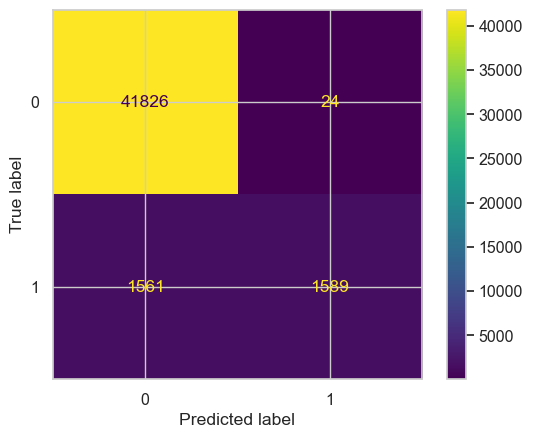

In [50]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:

# 3. Evaluation metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.9647777777777777
ROC-AUC: 0.9477609755172477

Confusion Matrix:
 [[41826    24]
 [ 1561  1589]]

Classification Report:
               precision    recall  f1-score   support

           0      0.964     0.999     0.981     41850
           1      0.985     0.504     0.667      3150

    accuracy                          0.965     45000
   macro avg      0.975     0.752     0.824     45000
weighted avg      0.965     0.965     0.959     45000



In [89]:
print('F1 score final LR model: ', round(metrics.f1_score(y_test, y_pred),4))
print('Recall score final LR model: ', round(metrics.recall_score(y_test, y_pred),4))
print('Precision score final LR model: ', round(metrics.precision_score(y_test, y_pred),4))
print('Accuracy score final LR model: ', round(metrics.accuracy_score(y_test, y_pred),4))

F1 score final LR model:  0.6672
Recall score final LR model:  0.5044
Precision score final LR model:  0.9851
Accuracy score final LR model:  0.9648


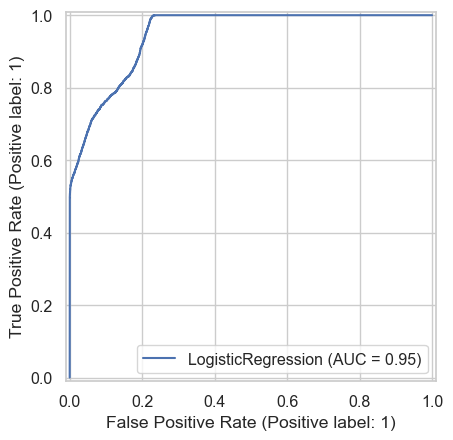

In [52]:
# 4. Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test_scaled, y_test)
plt.show()

**Observations:**
- We are getting a good F1 score of 66.72%, which implies there is a good balance of precision and recall.
- From Precision score, we see that ~98% of predicted positives (cancellations) were true positives (actual cancellations), however, from the total actual positives, this model only predicts ~50% (Recall) of  actual positives correctly. 
- We'll look for a better recall score in future models.

### Random Forest

In [205]:
# 1. Define parameter grid
cv_params = {
    'n_estimators': [50, 100],       # Number of trees
    'max_depth': [10, 20],       # Maximum depth of each tree
    'min_samples_split': [5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [2],       # Minimum samples required at a leaf node
    'max_features': ['log2']  # Number of features considered at each split
}

In [206]:
# 2. Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [207]:
# 3. Grid Search with Cross-Validation
# Using default 5-fold CV here; simpler and avoids PredefinedSplit complexity
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring='f1',        # Optimize for recall (important for cancelled rides)
    refit=True,
    cv=5,
    verbose=1
)

In [208]:
%%time
# 4. Fit GridSearch on training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 7min 11s
Wall time: 1min 15s


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20], 'max_features': ['log2'], 'min_samples_leaf': [2], 'min_samples_split': [5, 10], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [211]:
# 5. Best parameters & estimator
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [210]:
# 6. Predictions on test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

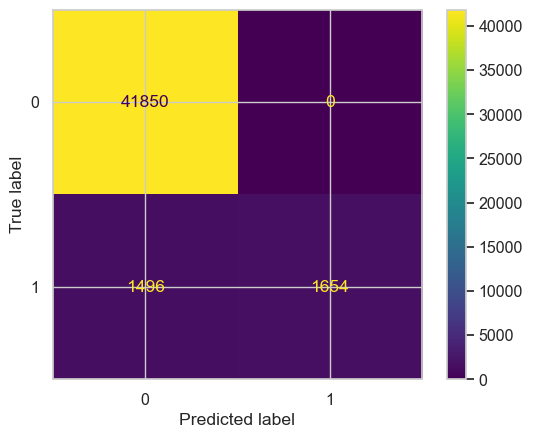

In [224]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_rf, labels=grid_search.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()

In [236]:
# 7. Evaluation Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

ROC-AUC: 0.9477609755172477

Confusion Matrix:
 [[41850     0]
 [ 1496  1654]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     41850
           1       1.00      0.53      0.69      3150

    accuracy                           0.97     45000
   macro avg       0.98      0.76      0.84     45000
weighted avg       0.97      0.97      0.96     45000

ROC-AUC Score: 0.9525569171834407


In [237]:
print('F1 score final RF model: ', round(metrics.f1_score(y_test, y_pred_rf),4))
print('Recall score final RF model: ', round(metrics.recall_score(y_test, y_pred_rf),4))
print('Precision score final RF model: ', round(metrics.precision_score(y_test, y_pred_rf),4))
print('Accuracy score final RF model: ', round(metrics.accuracy_score(y_test, y_pred_rf),4))

F1 score final RF model:  0.6886
Recall score final RF model:  0.5251
Precision score final RF model:  1.0
Accuracy score final RF model:  0.9668


**Observations:**
- We are getting a good F1 score of 68.86%, which implies there is a good balance of precision and recall.
- From Precision score, we see that ~100% of predicted positives (cancellations) were true positives (actual cancellations), from the total actual positives, this model predicts ~52.51% (Recall) of  actual positives correctly. This is better than the Logistic Regression model.
- We'll look for a better recall score in the XGBoost model.

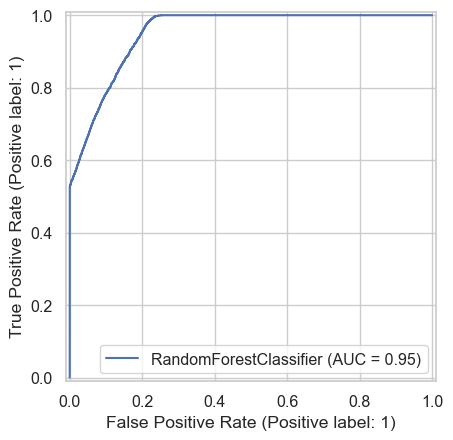

In [60]:
# 8. Plot ROC Curve
RocCurveDisplay.from_estimator(best_rf, X_test_scaled, y_test)
plt.show()

In [245]:
# 9. Feature Importance (top 10)
importances = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False).head(10).reset_index(drop= True)

importances

,feature,importance
0,avg_vtat,0.634450
1,payment_method_Unknown,0.100730
2,ride_distance,0.059163
3,booking_value,0.042476
4,avg_ctat,0.032253
5,customer_rating,0.025980
6,payment_method_UPI,0.025367
7,driver_ratings,0.021764
8,hour,0.007557
9,month,0.006646


### XGBoost

In [62]:
# 1. Initialize XGBoost & fit on training data

# scale_pos_weight = total_negatives / total_positives (useful for imbalanced datasets)
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',        # ROC-AUC evaluation
    scale_pos_weight=13.29,   # adjust based on class imbalance
    use_label_encoder=False,  
    random_state=42,
    n_jobs=-1
)



In [225]:
# Setting parameters & scoring for grid search
cv_params = {
    'max_depth': [50],
    'min_child_weight': [1],
    'min_samples_split': [3],
    'learning_rate': [0.3],
    'n_estimators': [100],
    'max_features': ['log2']
}

scoring= ['accuracy','precision','recall','f1']

In [226]:
# Initiate Grid Search 
xgb_cv= GridSearchCV(xgb, cv_params, scoring= scoring, cv = 5, refit= 'f1')


In [227]:
%%time
xgb_cv.fit(X_train_scaled, y_train)

CPU times: total: 3min 13s
Wall time: 29.1 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.3], 'max_depth': [50], 'max_features': ['log2'], 'min_child_weight': [1], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [239]:
# 2. Predictions & evaluate performance
y_pred_xgb = xgb_cv.predict(X_test_scaled)
y_prob_xgb = xgb_cv.predict_proba(X_test_scaled)[:, 1]  # probability for positive class

print("🎯 ROC AUC Score:", metrics.roc_auc_score(y_test, y_prob_xgb))
print("\n📋 Classification Report:\n", metrics.classification_report(y_test, y_pred_xgb, digits=3))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_xgb))

🎯 ROC AUC Score: 0.954720782841213

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.968     0.984     0.976     41850
           1      0.730     0.571     0.641      3150

    accuracy                          0.955     45000
   macro avg      0.849     0.778     0.809     45000
weighted avg      0.952     0.955     0.953     45000

Confusion Matrix:
 [[41186   664]
 [ 1351  1799]]


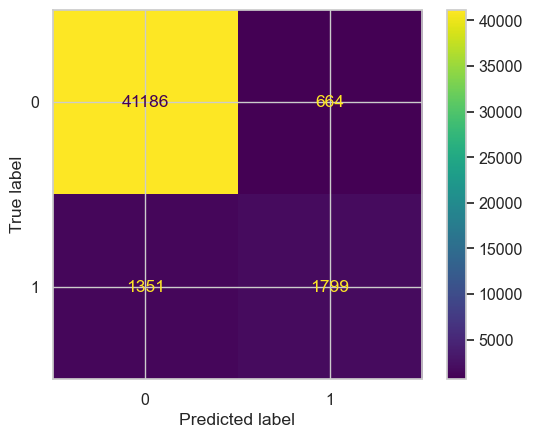

In [241]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_xgb, labels=xgb_cv.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)
disp.plot()

In [242]:
print('F1 score final XGB model: ', round(metrics.f1_score(y_test, y_pred_xgb),4))
print('Recall score final XGB model: ', round(metrics.recall_score(y_test, y_pred_xgb),4))
print('Precision score final XGB model: ', round(metrics.precision_score(y_test, y_pred_xgb),4))
print('Accuracy score final XGB model: ', round(metrics.accuracy_score(y_test, y_pred_xgb),4))

F1 score final XGB model:  0.641
Recall score final XGB model:  0.5711
Precision score final XGB model:  0.7304
Accuracy score final XGB model:  0.9552


**Observations:**
- We are getting a good F1 score of 64.10%, which implies there is a good balance of precision and recall.
- From Precision score, we see that ~73.04% of predicted positives (cancellations) were true positives (actual cancellations), from the total actual positives, this model predicts ~57.11% (Recall) of  actual positives correctly. This is better than the Logistic Regression model.
- The overall accuracy of the model is 95.52%. This looks like a balanced model, however, we are getting better metrics from Random Forest.

<Figure size 1000x600 with 0 Axes>

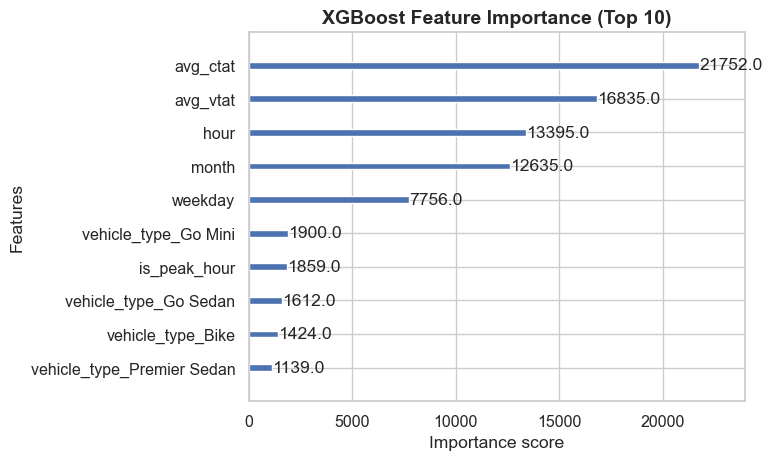

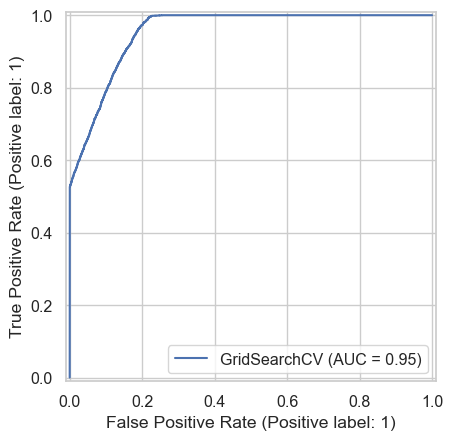

In [244]:
# 3. Feature Importance & ROC Curve
plt.figure(figsize=(10,6))
plot_importance(xgb_cv.best_estimator_, max_num_features=10)
plt.title("XGBoost Feature Importance (Top 10)", fontsize=14, weight='bold')
plt.show()

RocCurveDisplay.from_estimator(xgb_cv, X_test_scaled, y_test)
plt.show()

## 📊 Model Comparison Summary

| Model                | F1 Score | Recall  | Precision | Accuracy |
|----------------------|----------|---------|-----------|----------|
| Logistic Regression  | 0.6672   | 0.5044  | 0.9851    | 0.9648   |
| **Random Forest ✅ (Selected)** | **0.6886**  | **0.5251** | **1.0000**   | **0.9668**   |
| XGBoost              | 0.6410   | 0.5711  | 0.7304    | 0.9552   |


🔹 **Final Verdict**  

**Objective & Metric Choice**

- Our goal is to predict customer cancellations before the ride begins, to proactively identify high-risk rides and optimize driver dispatch.
- For this objective, we select F1 score as our primary metric as it ensures we are able to identify maximum cancellations with precision in prediction. 

**Model Selection**

- Random Forest Model achieves the highest F1 score (68.86%) and the highest Precision (100%). The Recall value (52.51%) is a bit lower than XGB.
- Although the Recall value is lower than XGB, we can see that our model doesn't have any False Positives, and which cancellation it predicts would most likely be correct.

📊 **Key Insights**
- High VTAT (Vehicle Arrival Time) strongly drives cancellations. Users are more likely to cancel rides when expected arrival times are long.
- 